# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [3]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [4]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6909, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6909 entries, 0 to 6908
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6909 non-null   int64  
 1   year                 6909 non-null   int64  
 2   productGrouping      6909 non-null   object 
 3   totalSpent           6909 non-null   float64
 4   recentDate           6909 non-null   object 
 5   attendancePercent    6909 non-null   float64
 6   renewedBeforeDays    6909 non-null   int64  
 7   source_tenure        6909 non-null   int64  
 8   tenure               6909 non-null   int64  
 9   distToVenue          6681 non-null   float64
 10  recency              6909 non-null   int64  
 11  missed_games_1       6909 non-null   int64  
 12  missed_games_2       6909 non-null   int64  
 13  missed_games_over_2  6909 non-null   int64  
 14  isNextYear_Buyer     6909 non-null   int64  
dtypes: float64(3), int64(10), object(2)
me

### We should specify the features used in our model:

In [6]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3596, 15)
Unseen Data For Predictions: (634, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [8]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [9]:
model_matrix = compare_models(
    fold=10,
    include=["lr","rf","xgboost","lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6325,0.6937,0.6648,0.6211,0.6416,0.2653,0.2666,0.1260
lr,Logistic Regression,0.6309,0.6878,0.6992,0.6120,0.6524,0.2625,0.2656,0.3470
lightgbm,Light Gradient Boosting Machine,0.6253,0.6915,0.6675,0.6118,0.6378,0.2510,0.2529,0.5530
xgboost,Extreme Gradient Boosting,0.6207,0.6831,0.6536,0.6096,0.6304,0.2418,0.2429,0.3510


In [10]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6176,0.6896,0.6974,0.5989,0.6444,0.2361,0.2393
1,0.5980,0.6599,0.6382,0.5879,0.6120,0.1965,0.1972
2,0.7092,0.7705,0.7697,0.6842,0.7245,0.4187,0.4220
3,0.6503,0.7142,0.7039,0.6331,0.6667,0.3011,0.3030
4,0.6438,0.7077,0.5987,0.6547,0.6254,0.2872,0.2882
5,0.6667,0.7263,0.7039,0.6524,0.6772,0.3336,0.3347
6,0.5869,0.6383,0.6159,0.5776,0.5962,0.1742,0.1746
7,0.5836,0.6517,0.5894,0.5779,0.5836,0.1673,0.1673
8,0.6361,0.7091,0.6623,0.6250,0.6431,0.2725,0.2730
9,0.6328,0.6698,0.6689,0.6196,0.6433,0.2661,0.2669


### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2679, 15)

In [12]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,42,2022,Flex Plan,312.0,1970-01-01,0.00,10,730,150,38.20,0,0,0,0,0,0,0.95,0.05
2,96,2022,Full Season,12257.0,2022-05-28,0.57,162,730,949,48.37,0,0,0,1,0,1,0.47,0.53
5,107,2022,Full Season,875.5,2022-05-14,0.43,159,730,950,57.52,1,2,1,0,0,0,0.56,0.44
7,138,2022,Full Season,850.0,2022-05-28,0.86,33,1095,1095,17.84,0,2,0,0,0,0,0.64,0.36
9,152,2022,Full Season,595.0,2022-05-28,1.00,101,730,1073,52.21,0,1,0,0,0,0,0.60,0.40


In [13]:
new_predictions["Label"].value_counts()

0    2361
1     318
Name: Label, dtype: int64

In [14]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.4, 0.6]       1285
(0.2, 0.4]        978
(-0.001, 0.2]     401
(0.6, 0.8]         15
(0.8, 1.0]          0
Name: Score_1, dtype: int64

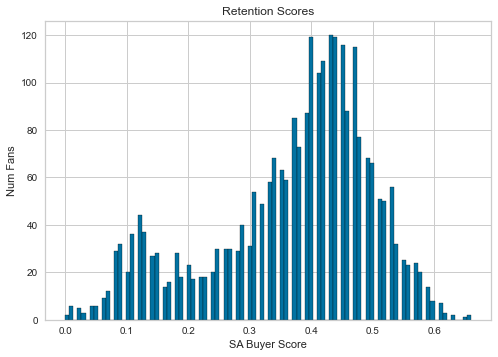

In [15]:
plt.hist(new_predictions["Score_1"], bins=100, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

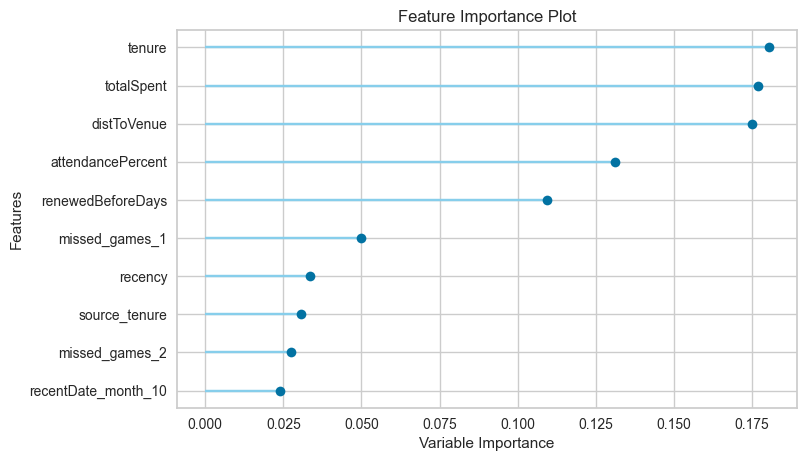

In [16]:
plot_model(best_model, plot='feature')

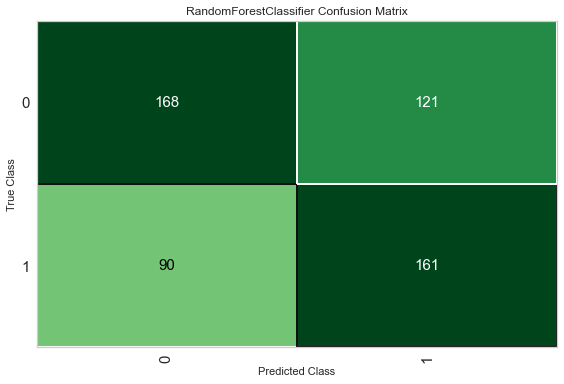

In [17]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above